## **PHẦN 1 – IMPORT + CONFIG**

In [ ]:
# ============================================================
# SETUP MÔI TRƯỜNG SEQ2SEQ CHO GOOGLE COLAB (1 CELL DUY NHẤT)
# ============================================================

# 1) Cập nhật pip
!pip install --upgrade pip

# 2) Cài torch CPU hoặc GPU tùy Colab hỗ trợ
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# 3) Cài các thư viện cần thiết
!pip install numpy matplotlib tqdm spacy nltk ipywidgets

# 4) Tải mô hình SpaCy EN & DE
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

# 5) Kiểm tra
import torch, spacy, nltk
print("PyTorch version:", torch.__version__)
print("SpaCy version:", spacy.__version__)
print("Device:", "GPU" if torch.cuda.is_available() else "CPU")

print("Setup hoàn tất! Bạn có thể chạy Seq2Seq ngay.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.2 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.7 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 115.8 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import requests

# Tạo thư mục data nếu chưa có
os.makedirs("data", exist_ok=True)

# File EN-DE từ Multi30K chuẩn (task1/tok)
files_map = {
    "train.en": "train.lc.norm.tok.en",
    "train.de": "train.lc.norm.tok.de",
    "val.en":   "val.lc.norm.tok.en",
    "val.de":   "val.lc.norm.tok.de",
    "test.en":  "test_2016_flickr.lc.norm.tok.en",
    "test.de":  "test_2016_flickr.lc.norm.tok.de"
}

base_url = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/tok/"

def download_file(fname, real_name):
    url = base_url + real_name
    save_path = os.path.join("data", fname)

    print(f"Downloading {fname} ← {real_name}")
    r = requests.get(url)

    if r.status_code == 200:
        with open(save_path, "wb") as f:
            f.write(r.content)
        print(f"✔ Saved: data/{fname}")
    else:
        print(f" Failed ({r.status_code}): {url}")

# Tải file
for fname, real_name in files_map.items():
    download_file(fname, real_name)

print("\n🎉 DONE — Multi30K EN–DE đã tải hoàn tất!")


✔ Saved: data/train.en
✔ Saved: data/train.de
✔ Saved: data/val.en
✔ Saved: data/val.de
✔ Saved: data/test.en
✔ Saved: data/test.de

🎉 DONE — Multi30K EN–DE đã tải hoàn tất!


In [5]:
# ============================================================
# PHẦN 1 – IMPORT & CONFIG (EN–DE)
# ============================================================

import os
os.environ["TORCHINDUCTOR_DISABLE"] = "1"   # tắt Inductor
os.environ["TORCH_COMPILE_DISABLE"] = "1"   # tắt torch.compile

import torch
try:
    torch._dynamo.config.suppress_errors = True
    torch._dynamo.disable()
except:
    pass
import random
import math
import time
import spacy
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Seed cố định
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed(SEED)

# Các token đặc biệt
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

SPECIAL_TOKENS = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

Using device: cuda


## **PHẦN 2 – TẢI DỮ LIỆU MULTI30K (EN–DE)**

In [8]:
# ============================================================
# PHẦN 2 – LOAD RAW MULTI30K EN–DE
# ============================================================

DATA_DIR = "data"

def load_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

# Load English–German
train_en = load_lines(os.path.join(DATA_DIR, "train.en"))
train_de = load_lines(os.path.join(DATA_DIR, "train.de"))

val_en   = load_lines(os.path.join(DATA_DIR, "val.en"))
val_de   = load_lines(os.path.join(DATA_DIR, "val.de"))

test_en  = load_lines(os.path.join(DATA_DIR, "test.en"))
test_de  = load_lines(os.path.join(DATA_DIR, "test.de"))

print("Train size:", len(train_en))
print("Val size:", len(val_en))
print("Test size:", len(test_en))

# ------------------------------------------------------------
# KIỂM TRA DỮ LIỆU SONG SONG 1–1
# ------------------------------------------------------------
assert len(train_en) == len(train_de)
assert len(val_en) == len(val_de)
assert len(test_en) == len(test_de)
print("EN–DE parallel data check passed (1–1 alignment confirmed)")

# ------------------------------------------------------------
# LỌC CÂU QUÁ DÀI (TỐI ƯU CHO CPU)
# ------------------------------------------------------------
MAX_LEN = 40  # giữ lại gần 99% dữ liệu
train_filtered = [(en, de) for en, de in zip(train_en, train_de)
                  if len(en.split()) <= MAX_LEN and len(de.split()) <= MAX_LEN]
train_en, train_de = zip(*train_filtered)
print(f"Filtered train size (≤{MAX_LEN} tokens):", len(train_en))


Train size: 29000
Val size: 1014
Test size: 1000
EN–DE parallel data check passed (1–1 alignment confirmed)
Filtered train size (≤40 tokens): 28998


## **PHẦN 3 – TOKENIZER**

In [9]:
# ============================================================
# PHẦN 3 – TOKENIZER (EN–DE) — DÀNH CHO GOOGLE COLAB
# ============================================================

# Nếu chưa có spacy, cài đặt nhanh (chạy 1 lần duy nhất)
!pip install -q spacy

# Tải model ngôn ngữ SpaCy (sẽ lưu trong runtime Colab)
!python -m spacy download en_core_web_sm > /dev/null
!python -m spacy download de_core_news_sm > /dev/null

import spacy

# Nạp 2 model SpaCy (EN & DE)
spacy_en = spacy.load("en_core_web_sm")
spacy_de = spacy.load("de_core_news_sm")

# Định nghĩa tokenizer
def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

print("Tokenizers for English & German are ready!")


Tokenizers for English & German are ready!


## **PHẦN 4 – BUILD VOCAB (EN–DE)**

In [10]:
# ============================================================
# PHẦN 4 – BUILD VOCAB (English–German)
# ============================================================

from collections import Counter

def build_vocab(texts, tokenizer, max_size=10000, min_freq=2):
    """
    Tạo vocabulary từ danh sách câu.
    - tokenizer: hàm tách token (SpaCy hoặc regex)
    - max_size: số lượng token tối đa (không tính token đặc biệt)
    - min_freq: chỉ giữ lại các từ xuất hiện >= min_freq lần
    """
    counter = Counter()
    for sent in texts:
        counter.update(tokenizer(sent))

    # Giữ các từ xuất hiện đủ nhiều
    vocab_freq = [w for w, c in counter.items() if c >= min_freq]
    # Chọn max_size từ phổ biến nhất và thêm token đặc biệt ở đầu
    vocab = SPECIAL_TOKENS + vocab_freq[:max_size]

    # Ánh xạ 2 chiều
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for i, w in enumerate(vocab)}

    return word2idx, idx2word

# ------------------------------------------------------------
# Tạo vocab riêng cho tiếng Anh và tiếng Đức
# ------------------------------------------------------------
en_word2idx, en_idx2word = build_vocab(train_en, tokenize_en, max_size=10000, min_freq=2)
de_word2idx, de_idx2word = build_vocab(train_de, tokenize_de, max_size=10000, min_freq=2)

# ------------------------------------------------------------
# Các chỉ số đặc biệt (token index)
# ------------------------------------------------------------
PAD_IDX = en_word2idx[PAD_TOKEN]
SOS_IDX = en_word2idx[SOS_TOKEN]
EOS_IDX = en_word2idx[EOS_TOKEN]
UNK_IDX = en_word2idx[UNK_TOKEN]

print("EN vocab size:", len(en_word2idx))
print("DE vocab size:", len(de_word2idx))

# ------------------------------------------------------------
# Kiểm tra nhanh top từ phổ biến nhất
# ------------------------------------------------------------
print("\nTop 10 EN words:", list(en_word2idx.keys())[4:14])
print("Top 10 DE words:", list(de_word2idx.keys())[4:14])
print("\n Vocabulary built successfully for English & German!")


EN vocab size: 5894
DE vocab size: 7857

Top 10 EN words: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes']
Top 10 DE words: ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe']

 Vocabulary built successfully for English & German!


## **PHẦN 5 – Dataset + DataLoader (EN–DE)**

In [11]:
# ============================================================
# PHẦN 5 – DATASET + DATALOADER (EN–DE) — CPU-Optimized
# ============================================================

class TranslationDataset(Dataset):
    def __init__(self, src_texts, trg_texts, src_tokenizer, trg_tokenizer,
                 src_w2i, trg_w2i):
        self.src = src_texts
        self.trg = trg_texts
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        self.src_w2i = src_w2i
        self.trg_w2i = trg_w2i

    def __len__(self):
        return len(self.src)

    def numericalize(self, tokens, w2i):
        return [w2i.get(tok, w2i[UNK_TOKEN]) for tok in tokens]

    def __getitem__(self, idx):
        src_sent = self.src[idx]
        trg_sent = self.trg[idx]

        src_tok = self.src_tokenizer(src_sent)
        trg_tok = self.trg_tokenizer(trg_sent)

        # Add <sos> / <eos> cho target
        trg_tok = [SOS_TOKEN] + trg_tok + [EOS_TOKEN]

        src_ids = self.numericalize(src_tok, self.src_w2i)
        trg_ids = self.numericalize(trg_tok, self.trg_w2i)

        return torch.tensor(src_ids), torch.tensor(trg_ids)


def collate_fn(batch):
    src_batch = [item[0] for item in batch]
    trg_batch = [item[1] for item in batch]

    src_lens = torch.tensor([len(x) for x in src_batch])
    trg_lens = torch.tensor([len(x) for x in trg_batch])

    # Sort giảm dần theo src_lens (bắt buộc nếu pack)
    src_lens, idx = src_lens.sort(descending=True)
    src_batch = [src_batch[i] for i in idx]
    trg_batch = [trg_batch[i] for i in idx]
    trg_lens = trg_lens[idx]

    src_pad = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_pad = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)

    return src_pad, trg_pad, src_lens, trg_lens


# Tạo dataset
train_ds = TranslationDataset(train_en, train_de, tokenize_en, tokenize_de,
                              en_word2idx, de_word2idx)
val_ds = TranslationDataset(val_en, val_de, tokenize_en, tokenize_de,
                            en_word2idx, de_word2idx)
test_ds = TranslationDataset(test_en, test_de, tokenize_en, tokenize_de,
                             en_word2idx, de_word2idx)

# DataLoader (CPU-optimized)
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=collate_fn, pin_memory=True)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

# Kiểm tra nhanh batch shape
for src, trg, src_lens, trg_lens in train_loader:
    print("src shape:", src.shape)
    print("trg shape:", trg.shape)
    print("src_lens:", src_lens[:5])
    break


Train batches: 907
Val batches: 32
Test batches: 32
src shape: torch.Size([32, 20])
trg shape: torch.Size([32, 23])
src_lens: tensor([20, 19, 19, 18, 18])


## **PHẦN 6 – ENCODER (LSTM)**

In [76]:
# ============================================================
# PHẦN 6 – ENCODER LSTM (CPU-Optimized)
# ============================================================

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lens):
        # src: [batch, src_len]
        embedded = self.dropout(self.embedding(src))
        # Pack padded sequence (safe for unsorted batch)
        packed = pack_padded_sequence(
            embedded, src_lens.cpu(),
            batch_first=True, enforce_sorted=False
        )
        outputs, (hidden, cell) = self.lstm(packed)

        # Optional: unpack outputs if you want to visualize or add Attention later
        outputs, _ = pad_packed_sequence(outputs, batch_first=True, padding_value=PAD_IDX)

        # outputs: [batch, seq_len, hidden_dim]
        # hidden, cell: [num_layers, batch, hidden_dim]
        return outputs, hidden, cell


## **PHẦN 7 – DECODER (LSTM)**

In [77]:
# ============================================================
# PHẦN 7 – DECODER LSTM (CPU-Optimized & Attention-Ready)
# ============================================================

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, cell):
        # input_token: [batch]
        input_token = input_token.unsqueeze(1)  # [batch, 1]
        embedded = self.dropout(self.embedding(input_token.long()))  # [batch, 1, emb_dim]

        # LSTM step
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output: [batch, 1, hidden_dim]

        prediction = self.fc_out(output.squeeze(1))  # [batch, output_dim]
        return prediction, hidden, cell


## **HẦN 8 – MODEL WRAPPER + TRAIN LOOP**

In [ ]:
# ============================================================
# PHẦN 8 – SEQ2SEQ + TRAIN LOOP (CPU-OPTIMIZED, FIXED)
# ============================================================

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_lens, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.size()
        output_dim = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, output_dim, device=DEVICE)

        # Encoder: bỏ outputs vì chưa dùng attention
        _, hidden, cell = self.encoder(src, src_lens)

        input_token = trg[:, 0]   # <sos>

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[:, t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1

        return outputs


# ============================================================
# CẤU HÌNH MÔ HÌNH & TRAINING – DÀNH CHO CPU
# ============================================================

INPUT_DIM = len(en_word2idx)
OUTPUT_DIM = len(de_word2idx)
BATCH_SIZE = 32
EMB_DIM = 256
HID_DIM = 384
N_LAYERS = 1
DROPOUT = 0.25
N_EPOCHS = 8

torch.set_num_threads(4)
# torch.set_num_interop_threads(4)

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(enc, dec).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# ============================================================
# TRAINING LOOP – EARLY STOPPING + TEACHER FORCING DECAY
# ============================================================

best_val = float("inf")
patience, no_improve = 2, 0
train_losses, val_losses = [], []

print("===== TRAINING (CPU MODE) =====")

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # Giảm dần teacher forcing theo epoch
    tf_ratio = max(0.6 * (0.97 ** epoch), 0.2)

    train_loss = train_epoch(model, train_loader, optimizer, criterion, tf_ratio)
    val_loss = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    elapsed = time.time() - start_time
    print(f"\nEpoch {epoch+1}/{N_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  TF Ratio:   {tf_ratio:.2f}")
    print(f"  Time:       {elapsed/60:.2f} min")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_model_cpu.pth")
        print("  ✅ Saved best model!")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("⏹ Early stopping: no improvement.")
            break

print("\n===== TRAINING FINISHED =====")
print(f"Best validation loss: {best_val:.4f}")


===== TRAINING (CPU MODE) =====

Epoch 1/8
  Train Loss: 4.3287
  Val Loss:   4.4245
  TF Ratio:   0.60
  Time:       19.01 min
  ✅ Saved best model!

Epoch 2/8
  Train Loss: 3.4735
  Val Loss:   4.0667
  TF Ratio:   0.58
  Time:       19.07 min
  ✅ Saved best model!

Epoch 3/8
  Train Loss: 3.0827
  Val Loss:   3.8431
  TF Ratio:   0.56
  Time:       18.89 min
  ✅ Saved best model!

Epoch 4/8
  Train Loss: 2.8059
  Val Loss:   3.6540
  TF Ratio:   0.55
  Time:       18.90 min
  ✅ Saved best model!

Epoch 5/8
  Train Loss: 2.5963
  Val Loss:   3.5447
  TF Ratio:   0.53
  Time:       18.75 min
  ✅ Saved best model!

Epoch 6/8
  Train Loss: 2.4269
  Val Loss:   3.4635
  TF Ratio:   0.52
  Time:       18.77 min
  ✅ Saved best model!

Epoch 7/8
  Train Loss: 2.2967
  Val Loss:   3.4050
  TF Ratio:   0.50
  Time:       18.74 min
  ✅ Saved best model!

Epoch 8/8
  Train Loss: 2.1840
  Val Loss:   3.3596
  TF Ratio:   0.48
  Time:       18.98 min
  ✅ Saved best model!

===== TRAINING FINISHED

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp best_model_cpu.pth /content/drive/MyDrive/best_model_cpu.pth
print("✔ Model saved to Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ Model saved to Google Drive!


In [ ]:
import pickle

with open("loss_history.pkl", "wb") as f:
    pickle.dump({"train": train_losses, "val": val_losses}, f)

!cp loss_history.pkl /content/drive/MyDrive/loss_history.pkl
print("✔ Loss history saved to Drive")


✔ Loss history saved to Drive


In [14]:
# ============================================================
# PHẦN 8 – SEQ2SEQ + TRAIN LOOP (CPU-OPTIMIZED, FIXED) - continue train
# ============================================================

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_lens, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.size()
        output_dim = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, output_dim, device=DEVICE)

        # Encoder: bỏ outputs vì chưa dùng attention
        _, hidden, cell = self.encoder(src, src_lens)

        input_token = trg[:, 0]   # <sos>

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[:, t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1

        return outputs


In [18]:
# ============================================================
# CẤU HÌNH MÔ HÌNH & TRAINING – DÀNH CHO CPU - continue train
# ============================================================

INPUT_DIM = len(en_word2idx)
OUTPUT_DIM = len(de_word2idx)
BATCH_SIZE = 32
EMB_DIM = 256
HID_DIM = 384
N_LAYERS = 1
DROPOUT = 0.25

torch.set_num_threads(4)
# torch.set_num_interop_threads(4)

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(enc, dec).to(DEVICE)


In [19]:
model.load_state_dict(torch.load("/content/drive/MyDrive/best_model_cpu.pth", map_location=DEVICE))
print("Model loaded successfully from Drive!")
model.train()


Model loaded successfully from Drive!


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5894, 256, padding_idx=0)
    (lstm): LSTM(256, 384, batch_first=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7857, 256, padding_idx=0)
    (lstm): LSTM(256, 384, batch_first=True)
    (fc_out): Linear(in_features=384, out_features=7857, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)


In [24]:
# ============================================================
# Đánh giá độ chính xác (token-level accuracy)
# ============================================================

def evaluate_metrics(model, loader):
    model.eval()
    total_tokens, correct_tokens = 0, 0

    with torch.no_grad():
        for src, trg, src_lens, _ in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            outputs = model(src, src_lens, trg, teacher_forcing_ratio=0)
            preds = outputs.argmax(2)

            mask = trg != PAD_IDX
            total_tokens += mask.sum().item()
            correct_tokens += ((preds == trg) & mask).sum().item()

    return 100 * correct_tokens / total_tokens


# ============================================================
# Tiếp tục train thêm 2 epoch (với Accuracy)
# ============================================================

best_val = float("inf")

START_EPOCH = 9
EXTRA_EPOCHS = 2
total_epochs = START_EPOCH + EXTRA_EPOCHS - 1

for epoch in range(START_EPOCH, total_epochs + 1):
    start_time = time.time()
    tf_ratio = max(0.5 * (0.97 ** epoch), 0.2)

    train_loss = train_epoch(model, train_loader, optimizer, criterion, tf_ratio)
    val_loss = evaluate(model, val_loader, criterion)
    val_acc = evaluate_metrics(model, val_loader)
    scheduler.step(val_loss)

    elapsed = time.time() - start_time
    print(f"\nEpoch {epoch}/{total_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Accuracy: {val_acc:.2f}%")
    print(f"  TF Ratio:   {tf_ratio:.2f}")
    print(f"  Time:       {elapsed/60:.2f} min")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/best_model_cpu.pth")
        print(" Saved new best model!")



Epoch 9/10
  Train Loss: 2.4290
  Val Loss:   3.2829
  Val Accuracy: 33.36%
  TF Ratio:   0.38
  Time:       19.79 min
 Saved new best model!

Epoch 10/10
  Train Loss: 2.2600
  Val Loss:   3.2356
  Val Accuracy: 34.14%
  TF Ratio:   0.37
  Time:       20.13 min
 Saved new best model!


## **TRAINING FUNCTION**

In [15]:
# ============================================================
# PHẦN PHỤ – TRAINING & EVALUATION HÀM (KHỚP CPU LOOP)
# ============================================================

def train_epoch(model, loader, optimizer, criterion, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0

    for src, trg, src_lens, _ in loader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()

        # ✅ truyền teacher_forcing_ratio động từ vòng for epoch
        outputs = model(src, src_lens, trg, teacher_forcing_ratio)

        # Bỏ <sos> khi tính loss
        outputs = outputs[:, 1:].reshape(-1, outputs.size(-1))
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(outputs, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg, src_lens, _ in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)

            # ✅ khi eval không dùng teacher forcing
            outputs = model(src, src_lens, trg, teacher_forcing_ratio=0)

            outputs = outputs[:, 1:].reshape(-1, outputs.size(-1))
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(outputs, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(loader)


## **TRAIN LẠI THEO ĐỀ**

In [78]:
# ============================================================
# CẤU HÌNH MÔ HÌNH & TRAINING – PHIÊN BẢN MỚI (512, 2 LAYERS)
# ============================================================

INPUT_DIM = len(en_word2idx)
OUTPUT_DIM = len(de_word2idx)
BATCH_SIZE = 64
EMB_DIM = 512
HID_DIM = 512
N_LAYERS = 2
DROPOUT = 0.35
N_EPOCHS = 15

torch.set_num_threads(4)

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(enc, dec).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

SAVE_PATH = "/content/drive/MyDrive/best_model_cpu.pth"
print(" Mô hình mới khởi tạo thành công (512 hidden, 2 layers)")


 Mô hình mới khởi tạo thành công (512 hidden, 2 layers)


In [79]:
# ============================================================
# HÀM ĐÁNH GIÁ (ACCURACY)
# ============================================================

def evaluate_metrics(model, loader):
    model.eval()
    total_tokens, correct_tokens = 0, 0
    with torch.no_grad():
        for src, trg, src_lens, _ in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            outputs = model(src, src_lens, trg, teacher_forcing_ratio=0)
            preds = outputs.argmax(2)
            mask = trg != PAD_IDX
            total_tokens += mask.sum().item()
            correct_tokens += ((preds == trg) & mask).sum().item()
    return 100 * correct_tokens / total_tokens

# ============================================================
# TRAINING VỚI LOG ĐẦY ĐỦ
# ============================================================

train_losses, val_losses, val_accuracies = [], [], []

best_val = float("inf")
patience, no_improve = 3, 0

print("===== TRAINING (512 hidden, 2 layers) =====")

for epoch in range(1, N_EPOCHS + 1):
    start_time = time.time()
    tf_ratio = max(0.5 * (0.97 ** epoch), 0.2)

    train_loss = train_epoch(model, train_loader, optimizer, criterion, tf_ratio)
    val_loss = evaluate(model, val_loader, criterion)
    val_acc = evaluate_metrics(model, val_loader)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    elapsed = time.time() - start_time
    print(f"\nEpoch {epoch}/{N_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Accuracy: {val_acc:.2f}%")
    print(f"  TF Ratio:   {tf_ratio:.2f}")
    print(f"  Time:       {elapsed/60:.2f} min")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"Saved new best model → {SAVE_PATH}")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

print("\nraining hoàn tất! Best validation loss:", best_val)

===== TRAINING (512 hidden, 2 layers) =====

Epoch 1/15
  Train Loss: 4.4988
  Val Loss:   4.3202
  Val Accuracy: 24.60%
  TF Ratio:   0.48
  Time:       1.17 min
Saved new best model → /content/drive/MyDrive/best_model_cpu.pth

Epoch 2/15
  Train Loss: 3.7007
  Val Loss:   3.9700
  Val Accuracy: 27.52%
  TF Ratio:   0.47
  Time:       1.13 min
Saved new best model → /content/drive/MyDrive/best_model_cpu.pth

Epoch 3/15
  Train Loss: 3.3243
  Val Loss:   3.7446
  Val Accuracy: 29.31%
  TF Ratio:   0.46
  Time:       1.15 min
Saved new best model → /content/drive/MyDrive/best_model_cpu.pth

Epoch 4/15
  Train Loss: 3.0537
  Val Loss:   3.6496
  Val Accuracy: 30.77%
  TF Ratio:   0.44
  Time:       1.13 min
Saved new best model → /content/drive/MyDrive/best_model_cpu.pth

Epoch 5/15
  Train Loss: 2.8480
  Val Loss:   3.4721
  Val Accuracy: 32.23%
  TF Ratio:   0.43
  Time:       1.13 min
Saved new best model → /content/drive/MyDrive/best_model_cpu.pth

Epoch 6/15
  Train Loss: 2.6705
  V

## **PHẦN 10 – HÀM DỊCH translate(sentence)**

In [81]:
# ============================================================
# HÀM DỊCH GREEDY – Seq2Seq KHÔNG CÓ ATTENTION
# ============================================================

def translate_greedy(model, sentence, max_len=50):
    model.eval()
    tokens = [tok.text.lower() for tok in spacy_en.tokenizer(sentence)]
    src_ids = [en_word2idx.get(tok, UNK_IDX) for tok in tokens]
    src_tensor = torch.tensor(src_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)
    src_len = torch.tensor([len(src_ids)], device=DEVICE)

    with torch.no_grad():
        _, hidden, cell = model.encoder(src_tensor, src_len)  # không cần encoder_outputs

    trg_indexes = [SOS_IDX]
    for _ in range(max_len):
        trg_tensor = torch.tensor([trg_indexes[-1]], device=DEVICE)
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == EOS_IDX:
            break

    trg_tokens = [de_idx2word[i] for i in trg_indexes[1:] if i not in [PAD_IDX, SOS_IDX, EOS_IDX]]
    return " ".join(trg_tokens)


In [71]:
# ============================================================
# LOAD LẠI MÔ HÌNH BEST_MODEL_CPU.PTH
# ============================================================

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model_cpu = Seq2Seq(enc, dec).to(DEVICE)

state_dict = torch.load("/content/drive/MyDrive/best_model_cpu.pth", map_location=DEVICE)
model_cpu.load_state_dict(state_dict)
model_cpu.eval()

print("Loaded best_model_cpu.pth thành công và chuyển sang chế độ eval")


Loaded best_model_cpu.pth thành công và chuyển sang chế độ eval


In [82]:
# ============================================================
# TEST DỊCH CÂU THỰC TẾ – CPU v2 (không attention)
# ============================================================

test_sentences = [
    "a man is sitting on a bench reading a book .",
    "a group of people are standing around a table with food .",
    "a woman in a red dress is dancing on stage .",
    "children are playing with toys in the park ."
]

print("===== TRANSLATION TEST (Seq2Seq – 512×2) =====")

for sent in test_sentences:
    output = translate_greedy(model_cpu, sent)
    print(f"\nEN: {sent}")
    print(f"DE (Greedy): {output}")


===== TRANSLATION TEST (Seq2Seq – 512×2) =====

EN: a man is sitting on a bench reading a book .
DE (Greedy): ein mann sitzt auf einer bank und liest ein buch .

EN: a group of people are standing around a table with food .
DE (Greedy): eine gruppe von menschen steht an einem tisch tisch herum .

EN: a woman in a red dress is dancing on stage .
DE (Greedy): eine frau in einem roten kleid tanzt auf der bühne .

EN: children are playing with toys in the park .
DE (Greedy): kinder spielen im park im park .


## **PHẦN 11 – TÍNH BLEU**

In [83]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_bleu(model, loader, max_batches=100):
    model.eval()
    smoothie = SmoothingFunction().method4
    refs, hyps = [], []

    with torch.no_grad():
        for i, (src, trg, src_lens, _) in enumerate(loader):
            if i >= max_batches:
                break
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            _, hidden, cell = model.encoder(src, src_lens)

            for b in range(src.size(0)):
                src_sent = " ".join([en_idx2word[x.item()] for x in src[b] if x.item() not in [PAD_IDX]])
                trg_tokens = [de_idx2word[y.item()] for y in trg[b] if y.item() not in [PAD_IDX, SOS_IDX, EOS_IDX]]
                pred = translate_greedy(model, src_sent)
                hyps.append(pred.split())
                refs.append([trg_tokens])

    bleu = corpus_bleu(refs, hyps, smoothing_function=smoothie)
    return bleu * 100

bleu_cpu = compute_bleu(model_cpu, val_loader)
print(f"BLEU Score (Seq2Seq no-attention): {bleu_cpu:.2f}")


BLEU Score (Seq2Seq no-attention): 21.06


## **PHẦN 12 – BIỂU ĐỒ LOSS**

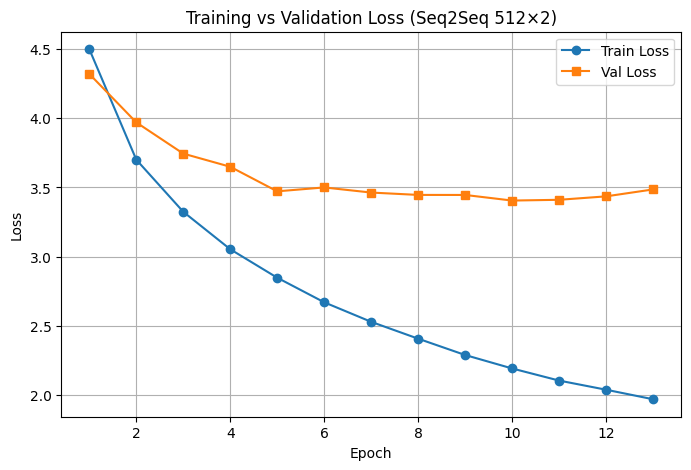

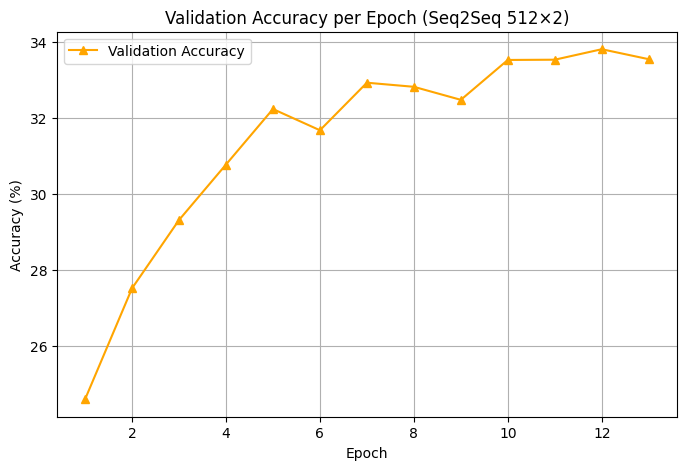

In [80]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 's-', label='Val Loss')
plt.title("Training vs Validation Loss (Seq2Seq 512×2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_accuracies, '^-', color='orange', label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch (Seq2Seq 512×2)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


## **PHẦN 13 – PHÂN TÍCH LỖI**

In [84]:
test_sentences = [
    "a man is sitting on a bench reading a book .",
    "a group of people are standing around a table with food .",
    "a woman in a red dress is dancing on stage .",
    "children are playing with toys in the park ."
]

for sent in test_sentences:
    output = translate_greedy(model_cpu, sent)
    print(f"\nEN: {sent}")
    print(f"DE (Greedy): {output}")



EN: a man is sitting on a bench reading a book .
DE (Greedy): ein mann sitzt auf einer bank und liest ein buch .

EN: a group of people are standing around a table with food .
DE (Greedy): eine gruppe von menschen steht an einem tisch tisch herum .

EN: a woman in a red dress is dancing on stage .
DE (Greedy): eine frau in einem roten kleid tanzt auf der bühne .

EN: children are playing with toys in the park .
DE (Greedy): kinder spielen im park im park .


## **TRAIN MÔ HÌNH CÓ ATTENTION**

In [85]:
# ============================================================
# PHẦN 6 – ENCODER LSTM (CPU-Optimized)
# ============================================================

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lens):
        # src: [batch, src_len]
        embedded = self.dropout(self.embedding(src))
        # Pack padded sequence (safe for unsorted batch)
        packed = pack_padded_sequence(
            embedded, src_lens.cpu(),
            batch_first=True, enforce_sorted=False
        )
        outputs, (hidden, cell) = self.lstm(packed)

        # Optional: unpack outputs if you want to visualize or add Attention later
        outputs, _ = pad_packed_sequence(outputs, batch_first=True, padding_value=PAD_IDX)

        # outputs: [batch, seq_len, hidden_dim]
        # hidden, cell: [num_layers, batch, hidden_dim]
        return outputs, hidden, cell


In [86]:
# ============================================================
# PHẦN 9 – ATTENTION (Luong-style)
# ============================================================

import torch.nn as nn
import torch

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden: [batch, hidden_dim]
        # encoder_outputs: [batch, src_len, hidden_dim]
        src_len = encoder_outputs.size(1)

        # Lặp hidden để cùng chiều với encoder_outputs
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        # Tính năng lượng (energy)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        # Trọng số attention (softmax theo chiều src_len)
        attention = self.v(energy).squeeze(2)

        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)

        return torch.softmax(attention, dim=1)


In [87]:
# ============================================================
# PHẦN 10 – DECODER with Attention
# ============================================================

class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(
            emb_dim + hidden_dim, hidden_dim, num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, cell, encoder_outputs):
        # input_token: [batch]
        input_token = input_token.unsqueeze(1)  # [batch, 1]
        embedded = self.dropout(self.embedding(input_token.long()))  # [batch, 1, emb_dim]

        # 1️⃣ Attention
        attn_weights = self.attention(hidden[-1], encoder_outputs)  # [batch, src_len]
        attn_weights = attn_weights.unsqueeze(1)                    # [batch, 1, src_len]

        # 2️⃣ Context vector
        context = torch.bmm(attn_weights, encoder_outputs)           # [batch, 1, hidden_dim]

        # 3️⃣ LSTM input: concat(embedding, context)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        # 4️⃣ Output token
        prediction = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1))

        return prediction, hidden, cell, attn_weights.squeeze(1)


In [88]:
# ============================================================
# PHẦN 11 – SEQ2SEQ with Attention
# ============================================================

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_lens, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.size()
        output_dim = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, output_dim, device=DEVICE)
        encoder_outputs, hidden, cell = self.encoder(src, src_lens)

        input_token = trg[:, 0]  # <sos>

        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(input_token, hidden, cell, encoder_outputs)
            outputs[:, t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1

        return outputs


In [89]:
# ============================================================
# PHẦN 12 – MODEL WITH ATTENTION (FINAL RECOMMENDED CONFIG)
# ============================================================

INPUT_DIM = len(en_word2idx)
OUTPUT_DIM = len(de_word2idx)
BATCH_SIZE = 64          # 64 là sweet spot (ổn định, nhanh)
EMB_DIM = 300            # đủ lớn cho Multi30k, tránh overfit
HID_DIM = 512            # mạnh mẽ, giúp context rõ hơn
N_LAYERS = 2             # đủ sâu, dễ train
DROPOUT = 0.25           # vừa đủ regularization
N_EPOCHS = 15
LR = 0.001
SAVE_PATH_ATT = "/content/drive/MyDrive/best_model_attention.pth"

attn = Attention(HID_DIM)
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = DecoderWithAttention(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT, attn)
model = Seq2SeqWithAttention(enc, dec).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

print(" Model with Attention ready to train!")
print(f"Embedding={EMB_DIM}, Hidden={HID_DIM}, Layers={N_LAYERS}, Dropout={DROPOUT}")


 Model with Attention ready to train!
Embedding=300, Hidden=512, Layers=2, Dropout=0.25


In [90]:
print(model)


Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(5894, 300, padding_idx=0)
    (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.25)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(7857, 300, padding_idx=0)
    (lstm): LSTM(812, 512, num_layers=2, batch_first=True, dropout=0.25)
    (fc_out): Linear(in_features=1024, out_features=7857, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)


In [91]:
best_val = float("inf")
patience, no_improve = 3, 0
N_EPOCHS = 15

print("===== TRAINING (with Attention) =====")

for epoch in range(1, N_EPOCHS + 1):
    start_time = time.time()
    tf_ratio = max(0.5 * (0.97 ** epoch), 0.2)

    train_loss = train_epoch(model, train_loader, optimizer, criterion, tf_ratio)
    val_loss = evaluate(model, val_loader, criterion)
    val_acc = evaluate_metrics(model, val_loader)
    scheduler.step(val_loss)

    elapsed = (time.time() - start_time) / 60
    print(f"\nEpoch {epoch}/{N_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Accuracy: {val_acc:.2f}%")
    print(f"  TF Ratio:   {tf_ratio:.2f}")
    print(f"  Time:       {elapsed:.2f} min")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), SAVE_PATH_ATT)
        print(f"Saved new best model → {SAVE_PATH_ATT}")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping: no improvement.")
            break

print(f"\nTraining complete! Best Val Loss = {best_val:.4f}")


===== TRAINING (with Attention) =====

Epoch 1/15
  Train Loss: 4.2771
  Val Loss:   3.8515
  Val Accuracy: 29.60%
  TF Ratio:   0.48
  Time:       1.63 min
Saved new best model → /content/drive/MyDrive/best_model_attention.pth

Epoch 2/15
  Train Loss: 3.1823
  Val Loss:   3.3972
  Val Accuracy: 33.41%
  TF Ratio:   0.47
  Time:       1.63 min
Saved new best model → /content/drive/MyDrive/best_model_attention.pth

Epoch 3/15
  Train Loss: 2.6936
  Val Loss:   3.1943
  Val Accuracy: 35.52%
  TF Ratio:   0.46
  Time:       1.64 min
Saved new best model → /content/drive/MyDrive/best_model_attention.pth

Epoch 4/15
  Train Loss: 2.3851
  Val Loss:   3.0578
  Val Accuracy: 37.61%
  TF Ratio:   0.44
  Time:       1.63 min
Saved new best model → /content/drive/MyDrive/best_model_attention.pth

Epoch 5/15
  Train Loss: 2.1411
  Val Loss:   3.0521
  Val Accuracy: 36.92%
  TF Ratio:   0.43
  Time:       1.63 min
Saved new best model → /content/drive/MyDrive/best_model_attention.pth

Epoch 6/15


In [92]:
attn = Attention(HID_DIM)
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = DecoderWithAttention(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT, attn)
model = Seq2SeqWithAttention(enc, dec).to(DEVICE)

model.load_state_dict(torch.load("/content/drive/MyDrive/best_model_attention.pth", map_location=DEVICE))
model.eval()
print("Model loaded successfully and ready for inference!")


Model loaded successfully and ready for inference!


## **PHẦN 10 – HÀM DỊCH translate(sentence) có attention**

In [93]:
# Hàm Greedy Decoding

def translate_greedy(model, sentence, max_len=50):
    model.eval()

    # Tokenize & convert sang index
    tokens = [tok.text.lower() for tok in spacy_en.tokenizer(sentence)]
    src_ids = [en_word2idx.get(tok, UNK_IDX) for tok in tokens]
    src_tensor = torch.tensor(src_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)
    src_len = torch.tensor([len(src_ids)], device=DEVICE)

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)

    trg_indexes = [SOS_IDX]
    for _ in range(max_len):
        trg_tensor = torch.tensor([trg_indexes[-1]], device=DEVICE)
        with torch.no_grad():
            output, hidden, cell, _ = model.decoder(trg_tensor, hidden, cell, encoder_outputs)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == EOS_IDX:
            break

    trg_tokens = [de_idx2word[i] for i in trg_indexes[1:] if i not in [PAD_IDX, SOS_IDX, EOS_IDX]]
    return " ".join(trg_tokens)


In [94]:
print(translate_greedy(model, "a man is riding a bike ."))


ein mann fährt fahrrad .


In [95]:
# Hàm Beam Search Decoding
import heapq

def translate_beam_search(model, sentence, beam_size=3, max_len=50):
    model.eval()

    tokens = [tok.text.lower() for tok in spacy_en.tokenizer(sentence)]
    src_ids = [en_word2idx.get(tok, UNK_IDX) for tok in tokens]
    src_tensor = torch.tensor(src_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)
    src_len = torch.tensor([len(src_ids)], device=DEVICE)

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)

    # (score, seq, hidden, cell)
    beams = [(0, [SOS_IDX], hidden, cell)]

    for _ in range(max_len):
        new_beams = []
        for score, seq, h, c in beams:
            trg_input = torch.tensor([seq[-1]], device=DEVICE)
            with torch.no_grad():
                output, h, c, _ = model.decoder(trg_input, h, c, encoder_outputs)
                log_probs = torch.log_softmax(output, dim=1)
                topk = torch.topk(log_probs, beam_size)
            for i in range(beam_size):
                next_tok = topk.indices[0][i].item()
                next_score = score + topk.values[0][i].item()
                new_beams.append((next_score, seq + [next_tok], h, c))
        beams = heapq.nlargest(beam_size, new_beams, key=lambda x: x[0])
        if all(seq[-1] == EOS_IDX for _, seq, _, _ in beams):
            break

    best_seq = beams[0][1]
    trg_tokens = [de_idx2word[i] for i in best_seq[1:] if i not in [PAD_IDX, SOS_IDX, EOS_IDX]]
    return " ".join(trg_tokens)


In [96]:
print(translate_beam_search(model, "a man is riding a bike .", beam_size=3))


ein mann fährt auf einem fahrrad .


In [97]:
sents = [
  "a group of people are standing around a table with food .",
  "a man is sitting on a bench reading a book .",
  "a woman in a red dress is dancing on stage .",
  "children are playing with toys in the park ."
]

for s in sents:
    print("EN:", s)
    print("🔹 Greedy:", translate_greedy(model, s))
    print("🔹 Beam Search (3):", translate_beam_search(model, s, beam_size=3))
    print()


EN: a group of people are standing around a table with food .
🔹 Greedy: eine gruppe von menschen steht um einen tisch mit essen .
🔹 Beam Search (3): eine gruppe von menschen steht um einen tisch mit essen .

EN: a man is sitting on a bench reading a book .
🔹 Greedy: ein mann sitzt auf einer bank und liest ein buch .
🔹 Beam Search (3): ein mann sitzt auf einer bank und liest ein buch .

EN: a woman in a red dress is dancing on stage .
🔹 Greedy: eine frau in einem roten kleid tanzt auf auf einer bühne .
🔹 Beam Search (3): eine frau in einem roten kleid tanzt auf der bühne .

EN: children are playing with toys in the park .
🔹 Greedy: kinder spielen mit einem im park .
🔹 Beam Search (3): kinder spielen mit hula-hoop-reifen im park .



In [45]:
!ls /content/drive/MyDrive | grep best_model


best_model_attention.pth
best_model_cpu.pth
best_model_cpu_v2.pth


## **PHẦN 11 – TÍNH BLEU có attention**

In [98]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_bleu(model, loader, max_batches=100):
    model.eval()
    smoothie = SmoothingFunction().method4
    refs, hyps = [], []

    with torch.no_grad():
        for i, (src, trg, src_lens, _) in enumerate(loader):
            if i >= max_batches:
                break

            src, trg = src.to(DEVICE), trg.to(DEVICE)
            encoder_outputs, hidden, cell = model.encoder(src, src_lens)

            for b in range(src.size(0)):
                # Tạo câu nguồn & đích
                src_sent = " ".join([en_idx2word[x.item()] for x in src[b] if x.item() not in [PAD_IDX]])
                trg_tokens = [de_idx2word[y.item()] for y in trg[b] if y.item() not in [PAD_IDX, SOS_IDX, EOS_IDX]]

                # Dịch Greedy
                pred = translate_greedy(model, src_sent)
                hyps.append(pred.split())
                refs.append([trg_tokens])

    bleu = corpus_bleu(refs, hyps, smoothing_function=smoothie)
    return bleu * 100

bleu_att = compute_bleu(model, val_loader)
print(f"BLEU Score (Attention Model): {bleu_att:.2f}")


BLEU Score (Attention Model): 28.41


## **PHẦN 12 – BIỂU ĐỒ LOSS có attention**

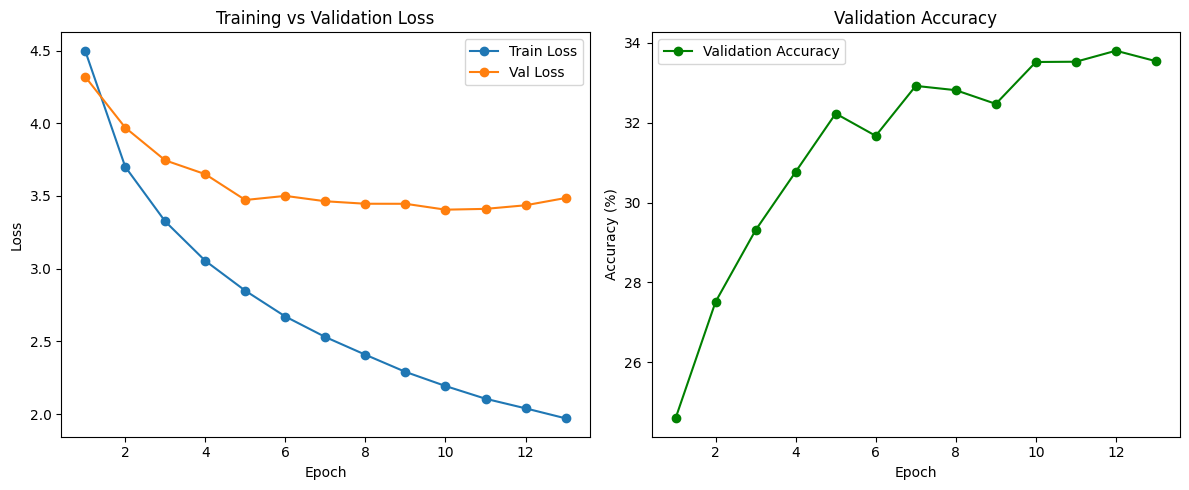

In [99]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


## **PHẦN 13 – PHÂN TÍCH LỖI có attention**


In [100]:
test_sentences = [
    "a group of people are standing around a table with food .",
    "a man is sitting on a bench reading a book .",
    "a woman in a red dress is dancing on stage .",
    "children are playing with toys in the park ."
]

for sent in test_sentences:
    greedy = translate_greedy(model, sent)
    print(f"\nEN: {sent}")
    print(f"DE (Greedy): {greedy}")



EN: a group of people are standing around a table with food .
DE (Greedy): eine gruppe von menschen steht um einen tisch mit essen .

EN: a man is sitting on a bench reading a book .
DE (Greedy): ein mann sitzt auf einer bank und liest ein buch .

EN: a woman in a red dress is dancing on stage .
DE (Greedy): eine frau in einem roten kleid tanzt auf auf einer bühne .

EN: children are playing with toys in the park .
DE (Greedy): kinder spielen mit einem im park .
